<a href="https://colab.research.google.com/github/zahraDehghanian97/stock_market/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import glob


In [2]:
! curl -L https://api.github.com/repos/zahraDehghanian97/stock_market/tarball --output repo.tar
! tar xf repo.tar --wildcards "*/tickers_data/*.csv" --strip-components=1 
! rm -rf repo.tar


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7402k    0 7402k    0     0  4693k      0 --:--:--  0:00:01 --:--:-- 6369k


In [6]:
def load_df_from_csv(dir_name:str) -> dict:
  stocks = {}
  for file_name in sorted(glob.glob(dir_name+'/*.csv')):
    df = pd.read_csv(file_name,names=['close'])
    dataset_name = file_name.split("/")[1].split(".csv")[0]
    print(dataset_name)
    stocks[dataset_name] = df
  return stocks

stocks = load_df_from_csv(dir_name="tickers_data")

def evaluate_performance(testing_actual, testing_predict):
    counter = 0
    for i in range(len(testing_actual)-1):
        predict=testing_predict[i+1]- testing_predict[i]
        actual = testing_actual[i+1]-testing_actual[i]
        if (actual > 0 and predict > 0) or (actual < 0 and predict < 0):
            counter+=1
    counter = round((counter / (len(testing_actual)-1))*100,2)
    return counter


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


prices_stock_yahoo
خچرخش
شپنا


Epoch 1/50
3/3 [==============================] - 4s 416ms/step - loss: 0.0436 - val_loss: 0.0421
Epoch 2/50
3/3 [==============================] - 0s 68ms/step - loss: 0.0406 - val_loss: 0.0404
Epoch 3/50
3/3 [==============================] - 0s 66ms/step - loss: 0.0395 - val_loss: 0.0372
Epoch 4/50
3/3 [==============================] - 0s 63ms/step - loss: 0.0366 - val_loss: 0.0338
Epoch 5/50
3/3 [==============================] - 0s 65ms/step - loss: 0.0325 - val_loss: 0.0299
Epoch 6/50
3/3 [==============================] - 0s 65ms/step - loss: 0.0287 - val_loss: 0.0260
Epoch 7/50
3/3 [==============================] - 0s 65ms/step - loss: 0.0247 - val_loss: 0.0218
Epoch 8/50
3/3 [==============================] - 0s 69ms/step - loss: 0.0199 - val_loss: 0.0160
Epoch 9/50
3/3 [==============================] - 0s 66ms/step - loss: 0.0143 - val_loss: 0.0090
Epoch 10/50
3/3 [==============================] - 0s 62ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 11/50
3/3 [===========

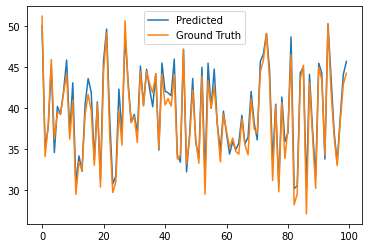

In [7]:
prices = pd.read_csv('tickers_data/prices_stock_yahoo.csv', index_col=['date'])
# selecting YHOO stocks
yahoo = prices[prices['symbol']=='YHOO']

# preparing input features
yahoo = yahoo.drop(['symbol'], axis=1)
yahoo = yahoo.drop(['volume'], axis=1)
yahoo = yahoo[['open', 'low', 'high', 'close']]

# preparing label data
yahoo_shift = yahoo.shift(-1)
label = yahoo_shift['close']

# adjusting the shape of both
yahoo.drop(yahoo.index[len(yahoo)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

# conversion to numpy array
x, y = yahoo.values, label.values

# scaling values for model
x_scale = MinMaxScaler()
y_scale = MinMaxScaler()

X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,1))

# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train = X_train.reshape((-1,1,4))
X_test = X_test.reshape((-1,1,4))

# creating model using Keras
# tf.reset_default_graph()

model_name = 'stock_price_GRU'

model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 4)))
model.add(Dropout(0.2))
model.add(GRU(units=256))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')

# model = load_model("{}.h5".format(model_name))
# print("MODEL-LOADED")

model.fit(X_train,y_train,batch_size=250, epochs=50, validation_split=0.1, verbose=1)
model.save("{}.h5".format(model_name))
print('MODEL-SAVED')

score = model.evaluate(X_test, y_test)
print('Score: {}'.format(score))
yhat = model.predict(X_test)

print("-------------------------------")
print('evaluating performance...')
accuracy_model = evaluate_performance(y_test, yhat)
print('Testing Accuracy: ', accuracy_model,"%")


yhat = y_scale.inverse_transform(yhat)
y_test = y_scale.inverse_transform(y_test)
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Ground Truth')
plt.legend()
plt.show()